In [29]:
import os
import sys
import numpy as np
import pandas as pd
import scipy.stats
#%matplotlib widget
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from tqdm import tqdm
from scipy.stats import tukey_hsd

In [30]:
"""Modify base_path to point to the folder containing the scripts folder"""
base_path = os.getcwd()
base_path = base_path.replace('notebooks', 'scripts') # note: if you have notebooks twice in your base_path, this won't work
sys.path.insert(1, base_path)

from helpers import *
from utils import remove_top_right_frame, jitter_scatterplot


In [31]:
#Make paths
cwd = os.getcwd()
tmpdir = os.path.normpath(cwd + os.sep + os.pardir)
main_dir = os.path.normpath(tmpdir + os.sep + os.pardir)

print(main_dir)

C:\Users\xagao\OneDrive\Bureau\bio482_miniproject


In [32]:
"""Load data"""
print('Main working directory:', main_dir)
figure_path = os.path.join(main_dir, 'python', 'figures')
os.makedirs(figure_path, exist_ok=True)
data_path = os.path.join(main_dir, 'python/data') #if your folder is organized differently, just specify the full path to the file

fname = 'data_bio482-001.pkl'
data_df = pd.read_pickle(os.path.join(data_path, fname))

Main working directory: C:\Users\xagao\OneDrive\Bureau\bio482_miniproject


In [33]:
"""Create a subset of the data for the analysis of Free Whisking"""
sweep_type = 'free whisking'
time_window = 2    # time window to analyze Vm (s)
freq_band_lim = [1, 10, 30, 90] # low- and high-frequency band limits (Hz)

#data_df_subset = data_df[data_df["Sweep_Type"]==sweep_type]
#data_df_subset = data_df[data_df['Sweep_Type']==sweep_type]
data_df_subset = data_df
all_cells = np.unique(data_df_subset.Cell_ID)
print('Number of cells:', len(all_cells))

Number of cells: 240


In [34]:
data_df[data_df["Cell_Anatomy"]=='L5']

,Cell_APThreshold_Slope,Cell_Anatomy,Cell_Counter,Cell_Depth,Cell_ID,Cell_Layer,Cell_TargetedBrainArea,Cell_Type,Cell_tdTomatoExpressing,Mouse_DateOfBirth,...,Sweep_Counter,Sweep_MembranePotential,Sweep_MembranePotential_SamplingRate,Sweep_PassiveContactTimes,Sweep_QuietTimes,Sweep_StartTime,Sweep_Type,Sweep_WhiskerAngle,Sweep_WhiskerAngle_SamplingRate,Sweep_WhiskingTimes
10,10.0,L5,1.0,550.0,SC903_1,L5,C2,EXC,False,NaN,...,1.0,"[-0.050484375, -0.050425, -0.05049375, -0.0505...",20000.0,"[6.461, 6.775]","[[0.002, 0.01], [6.226, 6.852], [9.71, 10.946]...",2005.0,active touch,"[11.55361080427187, 5.866629462925175, 0.06826...",100.0,"[[0.01, 5.386], [6.858, 9.516], [10.952, 11.68..."
39,10.0,L5,1.0,650.0,SC909_1,L5,C2,EXC,False,NaN,...,1.0,"[-0.065865625, -0.065815625, -0.06586875, -0.0...",20000.0,nan,"[[0.002, 0.47], [7.884, 8.814], [8.908, 10.046...",2006.0,active touch,"[-1.041554908752434, -1.2676734924316344, -1.2...",100.0,"[[0.52, 2.574], [3.138, 3.71], [4.8, 7.63], [1..."
40,10.0,L5,1.0,650.0,SC909_1,L5,C2,EXC,False,NaN,...,2.0,"[-0.062940625, -0.06293125, -0.062915625, -0.0...",20000.0,nan,"[[0.002, 0.01], [3.22, 3.998], [19.908, 20.0]]",2006.0,active touch,"[13.879621095657347, 28.42545607566833, 41.225...",100.0,"[[0.01, 1.164], [1.796, 2.322], [4.062, 10.69]..."
41,10.0,L5,1.0,650.0,SC909_1,L5,C2,EXC,False,NaN,...,3.0,"[-0.0594875, -0.059484375, -0.059453125, -0.05...",20000.0,nan,"[[0.002, 0.03], [2.76, 4.998], [5.418, 8.746],...",2006.0,active touch,"[0.3423306179046551, 0.731303472518915, 2.2265...",100.0,"[[0.036, 0.488], [1.684, 2.246], [5.052, 5.414..."


In [35]:
data_df.groupby('Cell_Anatomy').describe()

Cell_APThreshold_Slope                                         \
                              count       mean       std   min   25%   50%   
Cell_Anatomy                                                                 
L2/3                          218.0  11.743119  5.509780  10.0  10.0  10.0   
L4                            128.0  17.734375  7.446909   0.0  10.0  15.0   
L5                              4.0  10.000000  0.000000  10.0  10.0  10.0   
nan                           481.0  16.361746  6.964651   0.0  10.0  15.0   

                         Cell_Counter            ... Sweep_StartTime          \
               75%   max        count      mean  ...             75%     max   
Cell_Anatomy                                     ...                           
L2/3          10.0  40.0        218.0  1.137615  ...          2009.0  2016.0   
L4            20.0  35.0        128.0  1.804688  ...          2016.0  2017.0   
L5            10.0  10.0          4.0  1.000000  ...          2006.0  2006.0   
nan           20.0  35.0        481.0  1.501040  ...          2015.0  2016.0   

             Sweep_WhiskerAngle_SamplingRate                                   \
                                       count   mean  std    min    25%    50%   
Cell_Anatomy                                                                    
L2/3                                   218.0  100.0  0.0  100.0  100.0  100.0   
L4                                     128.0  100.0  0.0  100.0  100.0  100.0   
L5                                       4.0  100.0  0.0  100.0  100.0  100.0   
nan                                    481.0  100.0  0.0  100.0  100.0  100.0   

                            
                75%    max  
Cell_Anatomy                
L2/3          100.0  100.0  
L4            100.0  100.0  
L5            100.0  100.0  
nan           100.0  100.0  

[4 rows x 64 columns]

In [62]:
data_df[data_df['Cell_Depth'].isna()]

,Cell_APThreshold_Slope,Cell_Anatomy,Cell_Counter,Cell_Depth,Cell_ID,Cell_Layer,Cell_TargetedBrainArea,Cell_Type,Cell_tdTomatoExpressing,Mouse_DateOfBirth,...,Sweep_Counter,Sweep_MembranePotential,Sweep_MembranePotential_SamplingRate,Sweep_PassiveContactTimes,Sweep_QuietTimes,Sweep_StartTime,Sweep_Type,Sweep_WhiskerAngle,Sweep_WhiskerAngle_SamplingRate,Sweep_WhiskingTimes
695,25.0,nan,2.0,NaN,AP032_2,L2/3,C2,PV,True,2015.0,...,1.0,"[-0.043900002, -0.043940626, -0.043962501, -0....",20000.0,nan,"[[0.002, 0.6], [4.856, 6.658], [7.136, 10.626]...",2015.0,free whisking,"[-137.0508, -137.0508, -137.6991, -137.6991, -...",100.0,"[[0.604, 1.634], [2.092, 4.786], [6.782, 7.132..."
723,25.0,nan,1.0,NaN,AP061_1,L2/3,C2,PV,True,2015.0,...,1.0,"[-0.053934377, -0.053981248, -0.054043751, -0....",20000.0,nan,"[[0.002, 1.606], [1.668, 5.258], [6.57, 7.4], ...",2015.0,free whisking,"[-141.6704, -139.2687, -139.8691, -141.07, -14...",100.0,"[7.404, 8.47]"
724,25.0,nan,1.0,NaN,AP061_1,L2/3,C2,PV,True,2015.0,...,2.0,"[-0.058571875, -0.058571875, -0.058546875, -0....",20000.0,nan,"[[0.002, 2.21], [2.248, 2.824], [5.984, 8.458]...",2015.0,free whisking,"[-145.8735, -145.8735, -145.8735, -145.8735, -...",100.0,"[2.848, 5.97]"
725,25.0,nan,1.0,NaN,AP061_1,L2/3,C2,PV,True,2015.0,...,3.0,"[-0.055190627, -0.055275001, -0.055356249, -0....",20000.0,nan,"[[0.002, 2.344], [2.362, 7.72], [7.744, 9.836]...",2015.0,free whisking,"[-147.0743, -147.0743, -147.0743, -147.0743, -...",100.0,"[[12.756, 15.276], [15.682, 15.922], [18.798, ..."
726,25.0,nan,1.0,NaN,AP061_1,L2/3,C2,PV,True,2015.0,...,4.0,"[-0.045990624, -0.045896877, -0.045850001, -0....",20000.0,nan,"[[0.002, 0.01], [0.536, 1.398], [2.89, 3.616],...",2015.0,free whisking,"[-160.284, -157.2818, -156.6813, -157.8822, -1...",100.0,"[[0.036, 0.46], [1.58, 2.846], [3.62, 3.97], [..."
727,25.0,nan,1.0,NaN,AP061_1,L2/3,C2,PV,True,2015.0,...,5.0,"[-0.050637498, -0.050656252, -0.05064375, -0.0...",20000.0,nan,"[[0.002, 4.146], [6.93, 9.222], [9.434, 13.402...",2015.0,free whisking,"[-145.273, -145.273, -145.273, -145.273, -145....",100.0,"[[4.154, 5.128], [5.564, 6.578], [13.404, 13.9..."
728,25.0,nan,1.0,NaN,AP061_1,L2/3,C2,PV,True,2015.0,...,6.0,"[-0.056031249, -0.056121875, -0.056181248, -0....",20000.0,nan,"[[0.002, 0.29], [1.388, 2.37], [2.888, 5.718],...",2015.0,free whisking,"[-147.0743, -147.0743, -147.6748, -148.8757, -...",100.0,"[[0.46, 1.384], [2.396, 2.748], [5.726, 5.98],..."
729,25.0,nan,1.0,NaN,AP061_1,L2/3,C2,PV,True,2015.0,...,7.0,"[-0.04756875, -0.047512501, -0.047474999, -0.0...",20000.0,nan,"[[0.002, 0.694], [1.636, 8.086], [8.136, 9.144...",2015.0,free whisking,"[-150.677, -150.0765, -150.677, -150.677, -150...",100.0,"[0.698, 1.63]"
730,25.0,nan,1.0,NaN,AP061_1,L2/3,C2,PV,True,2015.0,...,8.0,"[-0.051750001, -0.051778127, -0.051750001, -0....",20000.0,nan,"[[0.002, 1.256], [1.384, 2.148], [2.826, 3.916...",2015.0,free whisking,"[-146.4739, -145.8735, -146.4739, -146.4739, -...",100.0,"[[2.176, 2.824], [5.158, 5.564], [6.774, 7.142..."
731,25.0,nan,1.0,NaN,AP061_1,L2/3,C2,PV,True,2015.0,...,9.0,"[-0.051190626, -0.051240627, -0.051278125, -0....",20000.0,nan,"[[0.002, 0.17], [0.296, 4.616], [4.714, 6.27],...",2015.0,free whisking,"[-142.2708, -142.2708, -142.8713, -142.8713, -...",100.0,"[[6.38, 9.19], [19.664, 19.986]]"


In [55]:
#L2-L3, 250 μm; L3-L4, 400 μm; L4-L5, 600 μm
def define_layer(cell_depth):
    if cell_depth <= 250:
        return 'L2'
    elif 250 < cell_depth <= 400:
        return 'L3'
    elif 400 < cell_depth <= 600:
        return 'L4'
    elif cell_depth > 600:
        return 'L5'
    else:
        return str(cell_depth)
    
data_df[data_df["Cell_Anatomy"]=='nan']["Cell_Depth"].apply(lambda x: define_layer(x)).unique()

array(['L3', 'L4', 'L5', 'L2', 'nan'], dtype=object)

In [84]:
data_df["Layer"] = data_df["Cell_Depth"].apply(lambda x: define_layer(x))
#data_df[data_df["Layer"]=="nan"]["Layer"] = data_df[data_df["Layer"]=="nan"]["Cell_Layer"]

data_df.loc[data_df["Layer"]=="nan", "Layer"] = data_df.loc[data_df["Layer"]=="nan", "Cell_Layer"]
data_df["Layer"].unique()

array(['L2', 'L3', 'L4', 'L5', 'L2/3'], dtype=object)

In [85]:
"""Assert that all trials for a given cell have the same depth and layer"""
cell_list = sorted(np.unique(data_df_subset.Cell_ID), reverse=True) #NOTE: DO NOT START WITH AC32 bc. no AP and undefined ap_params content

for cell in cell_list:
    depth = data_df_subset[data_df_subset.Cell_ID==cell].Cell_Depth.values[0]
    layer = data_df_subset[data_df_subset.Cell_ID==cell].Cell_Anatomy.values[0]
    for dpeth in data_df_subset[data_df_subset.Cell_ID==cell].Cell_Depth:
        assert (depth == dpeth or np.isnan(depth)), 'Cell depth is not the same for all trials for cell {}'.format(cell)
    for layer1 in data_df_subset[data_df_subset.Cell_ID==cell].Cell_Anatomy:
        assert (layer1 == layer or np.isnan(layer1)), 'Cell layer is not the same for all trials for cell {}'.format(cell)    

In [ ]:
"""Create a dictionary to store data for all cells"""
verbose=False #set to 0 to hide individual AP plots

# Initialize a dictionary to store data for all cell
result_dict = {'cell_id': all_cells,
               'cell_layer': [],
               'cell_layer2': [],
               'cell_depth' : [],
               'cell_type':[], # required for cell-type identification
               # Data we'll collect for Part 1a
               'firing_rate': [],
               'ap_threshold': [],
               'ap_duration': [],
               # Data we'll collect for Part 1b
               'mean_vm':[],
               'std_vm':[],
               'fft_low':[],
               'fft_high':[]
               }

result_fft_cell_type = {'EXC':[],'SST':[], 'VIP':[],'PV':[]}

exc_cell_counter = 0

# Iterate over each cell identities to collect desired data
cell_list = sorted(np.unique(data_df_subset.Cell_ID), reverse=True) #NOTE: DO NOT START WITH AC32 bc. no AP and undefined ap_params content
for idx, cell in enumerate(tqdm(cell_list, desc='Processing Cells')):

    # Get mouse name and cell number from cell identifier
    mouse = cell.split('_')[0]
    cell_count = float(cell.split('_')[1])

    # Get data subset for that cell
    cell_df = data_df_subset[data_df_subset.Cell_ID==cell]

    # Get cell type 
    cell_type = cell_df.Cell_Type.values[0]
    result_dict['cell_type'] += [cell_type]
    result_dict['cell_depth'] += [cell_df.Cell_Depth.values[0]]
    result_dict['cell_layer'] += [cell_df.Cell_Anatomy.values[0]]
    result_dict['cell_layer2'] += [cell_df.Layer.values[0]]

    # Get sweeps/trials recorded for that cell, that we are going to iterate over
    trial_list = cell_df.Sweep_Counter.values

    # Init. cell recording specific quantities: a unique duration, yielding a unique number of APs
    tot_rec_duration = 0
    tot_number_ap = 0

    # Initialize empty lists to get data for each trial/sweep
    # Part 1a
    tot_ap_thresh = []
    tot_ap_duration = []
    # Part 1b
    tot_mean_vm = []
    tot_std_vm = []
    tot_fft = []

    # For that cell, iterate over trials
    for trial in trial_list:
        #if idx % 100 == 0: # print every 100 iteration  
        #print('Cell {},  trial {}'.format(cell, int(trial)))
        if cell_type == 'EXC':
            exc_cell_counter += 1
        
        # Get current trial data
        cell_trial_df = cell_df[cell_df.Sweep_Counter==trial]

        # Get the sampling rate and membrane potential (and derivative) from that sweep
        sr_vm = cell_trial_df['Sweep_MembranePotential_SamplingRate'].values[0] #[0] to get the content of the array
        membrane_potential = cell_trial_df['Sweep_MembranePotential'].values[0]
        ap_vm_deriv_thresh = cell_trial_df['Cell_APThreshold_Slope'].values[0]

        # Get and update recording duration for that cell by adding trial duration
        trial_rec_duration = len(membrane_potential)/sr_vm
        tot_rec_duration += trial_rec_duration

        # Detection of action potentials for that trial, and update total number of APs for that cell
        #ap_params = None
        ap_params = Function_Detect_APs(membrane_potential, sr_vm, ap_vm_deriv_thresh)
        tot_number_ap += ap_params.shape[0]

        # Check if this trial contains any AP...
        ap_duration = []
        if (ap_params.any()):
            ap_thresh_times = ap_params[:,0]
            ap_thresh_vm = ap_params[:,1]
            ap_peak_times = ap_params[:,2]
            ap_peak_vm = ap_params[:,3]
            ap_duration = ap_params[:,5] #check for no-APs (cells with no spikes in ALL trials:EXC5,16 FR=0, AP_dur=np.nan)

            #... if so, cut-out individual APs to keep subthreshold Vm only
            vm_sub = Function_CutAPs(membrane_potential, sr_vm, ap_peak_times, ap_thresh_times)


        # Else if no AP, subthreshold Vm is just Vm
        else:

            vm_sub = membrane_potential.copy()

        # Once Vm_sub is obtained:
        # Compute subthreshold Vm mean and standard deviation
        mean_vm, std_vm = Function_SubThrsVm(vm_sub, sr_vm, trial_rec_duration)

        # Compute trial FFT
        fft = Function_Compute_FFTs(vm_sub, sr_vm, time_window)

        #Update current variables from the current trial
        # Part 1a
        tot_ap_thresh += [np.concatenate([ap_thresh_vm])]
        tot_ap_duration += [ap_duration]
        # Part 1b
        tot_mean_vm += [mean_vm]
        tot_std_vm += [std_vm]
        tot_fft +=  [fft]

        # Optional plotting: show AP and AP peak times
        ap_peak_index=np.round(ap_peak_times * sr_vm)
        if verbose:
            fig, ax = plt.subplots(1,1, figsize=(10,2), dpi=300)
            remove_top_right_frame(ax)
            ax.set_title('Cell {},  trial {}'.format(cell, int(trial)))
            ax.plot(membrane_potential, lw=0.5,  zorder=0)
            ax.scatter(ap_peak_index, ap_peak_vm, lw=0.5, marker='+', color='r')
            ax.set_xlabel('Time (samples)')
            ax.set_ylabel('Membrane \n potential (V)')
            plt.show()

    # Once iterated over all trials for that cell, append cell data lists to the result dictionary

    # Part 1a
    result_dict['firing_rate'] += [tot_number_ap / tot_rec_duration] # <- just the firing rate formula
    result_dict['ap_threshold'] += [np.nanmean(np.concatenate(tot_ap_thresh))] #<-concatenate trials, get trial-average
    result_dict['ap_duration'] += [np.nanmean(np.concatenate(tot_ap_duration))]


    # Part 1b
    result_dict['mean_vm'] += [np.nanmean(np.concatenate(tot_mean_vm))]
    result_dict['std_vm'] += [np.nanmean(np.concatenate(tot_std_vm))]

    # Compute mean FFT over trials
    tot_fft = np.nanmean(np.concatenate(tot_fft, axis=1), 1)
    #Store mean cell FFT
    result_fft_cell_type[cell_type] += [tot_fft]

    # We need to find which point (sample) in the FFT correspond to which frequency
    pt1 = int(freq_band_lim[0] * fft.shape[0] / (sr_vm/2) ) + 1 #1Hz into FFT point
    pt2 = int(freq_band_lim[1] * fft.shape[0] / (sr_vm/2) ) + 1 #int: slicing requires integers
    result_dict['fft_low'] += [tot_fft[pt1:pt2].mean()]

    pt3 = int(freq_band_lim[2] * fft.shape[0] / (sr_vm/2) ) + 1
    pt4 = int(freq_band_lim[3] * fft.shape[0] / (sr_vm/2) ) + 1
    result_dict['fft_high'] += [tot_fft[pt3:pt4].mean()]

## Convert each dictionary lists as numpy arrays (convenient to make dataframes)
result_dict = {key: np.array(result_dict[key]) for key in result_dict.keys()}

print('Done!')

Processing Cells:  14%|█▍        | 34/240 [01:40<03:42,  1.08s/it]C:\Users\xagao\OneDrive\Bureau\bio482_miniproject\python\scripts\helpers.py:18: RuntimeWarning: invalid value encountered in divide
  AP_Thrs_Onset = np.diff(np.divide(Vm_Deriv - Vm_Deriv_Thrs, np.abs(Vm_Deriv - Vm_Deriv_Thrs)))
Processing Cells:  24%|██▍       | 58/240 [02:12<03:00,  1.01it/s]

In [25]:
saved_dict_path = 'depth_free_whisking.pickle'

if os.path.isfile(saved_dict_path):    
    with open(saved_dict_path, 'rb') as handle:
        result_dict = pickle.load(handle)
else:
    with open('savec_dict_path', 'wb') as handle:
        pickle.dump(result_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [39]:
saved_dict_path = 'depth_all_cell.pickle'

if os.path.isfile(saved_dict_path):
    with open(saved_dict_path, 'rb') as handle:
        result_dict = pickle.load(handle)
else:
    with open('savec_dict_path', 'wb') as handle:
        pickle.dump(result_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [40]:
result_df = pd.DataFrame(result_dict)

layer_df = result_df.groupby('cell_layer').describe()
layer_df

cell_depth                                                      \
                count        mean         std    min    25%    50%    75%   
cell_layer                                                                  
L2/3             37.0  252.567568   74.797334  140.0  197.0  244.0  320.0   
L4               41.0  444.829268   41.639466  351.0  425.0  444.0  463.0   
L5                2.0  600.000000   70.710678  550.0  575.0  600.0  625.0   
nan             158.0  321.765823  160.391963   97.0  176.5  277.0  467.0   

                  firing_rate             ...   fft_low           fft_high  \
              max       count       mean  ...       75%       max    count   
cell_layer                                ...                                
L2/3        396.0        37.0   6.524304  ...  0.000750  0.001144     37.0   
L4          570.0        41.0   9.043575  ...  0.000713  0.000965     41.0   
L5          650.0         2.0   0.650000  ...  0.000434  0.000449      2.0   
nan         665.0       160.0  11.282606  ...  0.000807  0.001223    160.0   

                                                                        \
                mean       std       min       25%       50%       75%   
cell_layer                                                               
L2/3        0.000055  0.000025  0.000019  0.000035  0.000053  0.000064   
L4          0.000066  0.000021  0.000031  0.000054  0.000062  0.000077   
L5          0.000061  0.000011  0.000053  0.000057  0.000061  0.000065   
nan         0.000063  0.000024  0.000019  0.000044  0.000057  0.000081   

                      
                 max  
cell_layer            
L2/3        0.000117  
L4          0.000138  
L5          0.000069  
nan         0.000128  

[4 rows x 64 columns]

In [41]:
#L2-L3, 250 μm; L3-L4, 400 μm; L4-L5, 600 μm
layer_df_labeled = layer_df.copy()
layer_df['cell_depth']

,count,mean,std,min,25%,50%,75%,max
cell_layer,,,,,,,,
L2/3,37.0,252.567568,74.797334,140.0,197.0,244.0,320.0,396.0
L4,41.0,444.829268,41.639466,351.0,425.0,444.0,463.0,570.0
L5,2.0,600.000000,70.710678,550.0,575.0,600.0,625.0,650.0
nan,158.0,321.765823,160.391963,97.0,176.5,277.0,467.0,665.0


In [9]:
cell_type_df = result_df.groupby('cell_type').describe()
cell_type_df

cell_depth                                                        \
               count        mean         std    min     25%    50%     75%   
cell_type                                                                    
EXC             86.0  378.069767  143.943844  120.0  250.00  393.5  472.25   
PV              47.0  334.787234  127.489290  158.0  214.50  338.0  458.00   
SST             72.0  323.291667  135.045161   97.0  198.25  347.5  444.75   
VIP             25.0  193.680000  140.274350   98.0  125.00  147.0  175.00   

                 firing_rate             ...   fft_low           fft_high  \
             max       count       mean  ...       75%       max    count   
cell_type                                ...                                
EXC        665.0        86.0   1.822975  ...  0.000782  0.001091     86.0   
PV         547.0        49.0  29.343396  ...  0.000948  0.001389     49.0   
SST        550.0        72.0   6.597538  ...  0.000540  0.000926     72.0   
VIP        571.0        25.0  12.718557  ...  0.000785  0.001063     25.0   

                                                                       \
               mean       std       min       25%       50%       75%   
cell_type                                                               
EXC        0.000054  0.000018  0.000019  0.000042  0.000052  0.000065   
PV         0.000093  0.000017  0.000043  0.000082  0.000095  0.000104   
SST        0.000056  0.000017  0.000028  0.000043  0.000051  0.000068   
VIP        0.000054  0.000020  0.000020  0.000044  0.000050  0.000068   

                     
                max  
cell_type            
EXC        0.000096  
PV         0.000130  
SST        0.000102  
VIP        0.000105  

[4 rows x 64 columns]

In [10]:
class_color = {'EXC':'k',
               'PV':'indianred',
               'VIP':'royalblue',
               'SST':'darkorange'}
cell_class_order = ['EXC', 'PV', 'VIP', 'SST']

result_df.dropna(inplace=True, subset=['cell_depth'])

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


Text(0.5, 1.0, 'Cell_depth - free whisking')

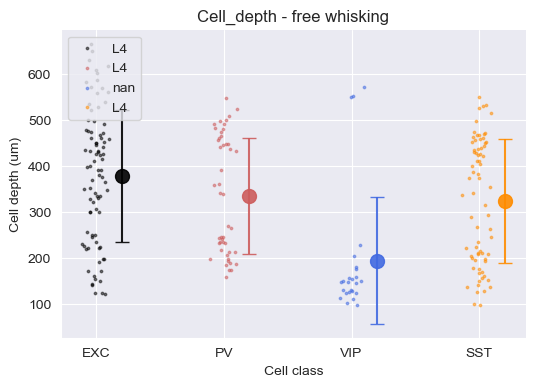

In [11]:
"""Plotting"""
# Define figure
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(6,4), dpi=100)
remove_top_right_frame(ax)

# Iterate over cell class
for i, c_type in enumerate(cell_class_order):

    n_cells = len(result_df[result_df.cell_type==c_type])
    obs_locations = [i]*n_cells #create a list int, to place observations categorically
    obs_values = result_df[result_df.cell_type==c_type]['cell_depth'].values
    
    print(type(obs_values))
    # Show individual observations (scatterplot with added x-axis jitter to avoid overplotting)
    jitter_scatterplot(x=obs_locations,
                       y=obs_values,
                       s=3,
                       alpha=0.5,
                       c=class_color[c_type],
                       label=result_df[result_df.cell_type==c_type]['cell_layer'].values[0])

    # Show mean and standard deviation
    ax.errorbar(x=i+0.2,
                y=np.mean(obs_values),
                yerr=np.std(obs_values), #errobarsize is standard deviation
                marker='o',
                ms=10,
                capsize=5,
                alpha=0.9,
                c=class_color[c_type])

# Set xtick labels and legend
ax.legend(loc='upper left', fontsize=10)
ax.set_xticks([0,1,2,3])
ax.set_xticklabels(cell_class_order)
ax.set_xlabel('Cell class')
ax.set_ylabel('Cell depth (um)')
ax.set_title('Cell_depth - free whisking')


In [12]:

Obs_EXC = result_df[result_df.cell_type=='EXC']['cell_depth'].values
Obs_PV = result_df[result_df.cell_type=='PV']['cell_depth'].values
Obs_VIP = result_df[result_df.cell_type=='VIP']['cell_depth'].values
Obs_SST = result_df[result_df.cell_type=='SST']['cell_depth'].values

Res=tukey_hsd(Obs_EXC, Obs_PV, Obs_VIP, Obs_SST)
print(Res)

Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)     43.283     0.308   -21.297   107.862
 (0 - 2)    184.390     0.000   103.497   265.282
 (0 - 3)     54.778     0.064    -2.091   111.648
 (1 - 0)    -43.283     0.308  -107.862    21.297
 (1 - 2)    141.107     0.000    52.979   229.235
 (1 - 3)     11.496     0.970   -55.266    78.257
 (2 - 0)   -184.390     0.000  -265.282  -103.497
 (2 - 1)   -141.107     0.000  -229.235   -52.979
 (2 - 3)   -129.612     0.000  -212.257   -46.967
 (3 - 0)    -54.778     0.064  -111.648     2.091
 (3 - 1)    -11.496     0.970   -78.257    55.266
 (3 - 2)    129.612     0.000    46.967   212.257


C:\Users\xagao\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\xagao\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\xagao\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\xagao\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_cat

<Axes: xlabel='cell_type', ylabel='cell_depth'>

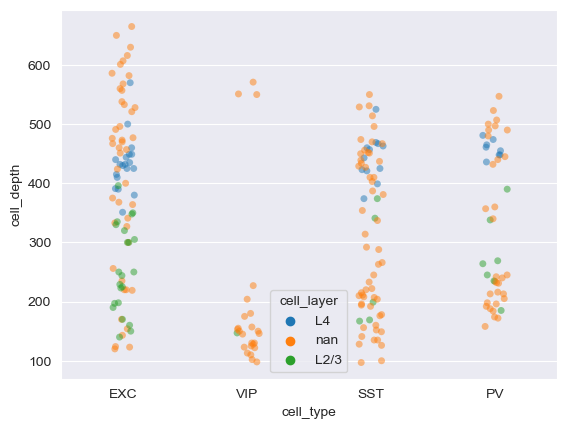

In [13]:
sns.stripplot(data=result_df, x="cell_type", y="cell_depth", jitter=True, alpha=0.5, hue='cell_layer')

C:\Users\xagao\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\xagao\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\xagao\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\xagao\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_cat

<Axes: xlabel='cell_layer', ylabel='cell_depth'>

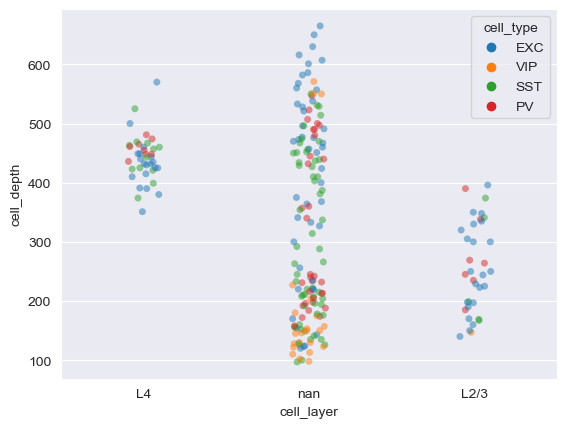

In [14]:
sns.stripplot(data=result_df, x="cell_layer", y="cell_depth", jitter=True, alpha=0.5, hue="cell_type")

C:\Users\xagao\AppData\Local\Temp\ipykernel_18552\2184752489.py:24: RuntimeWarning: Mean of empty slice
  y=np.nanmean(obs_values),
C:\Users\xagao\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


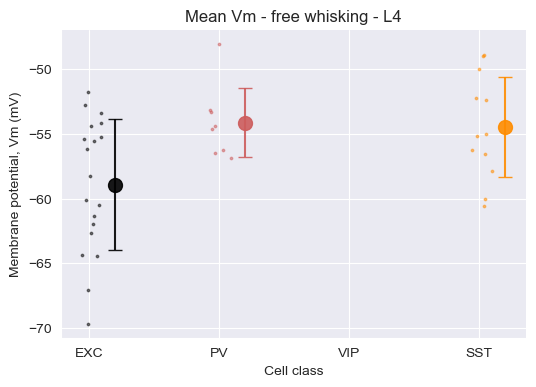

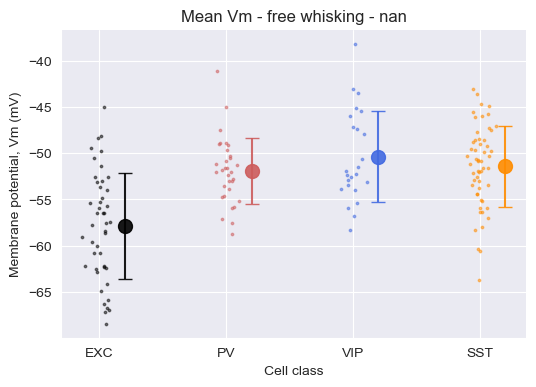

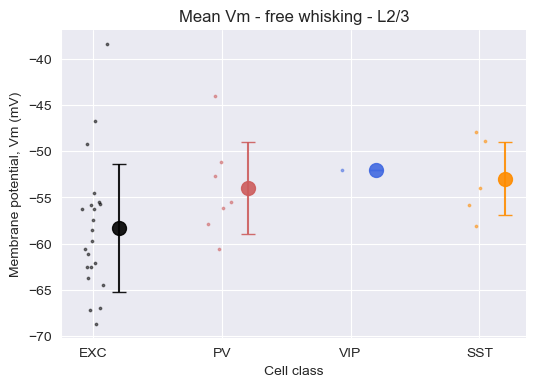

In [15]:
for layer in result_df.cell_layer.unique():
    
    l2 = result_df[result_df.cell_layer==layer]
    # Define figure
    fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(6,4), dpi=100)
    remove_top_right_frame(ax)
    
    # Iterate over cell class
    for i, c_type in enumerate(cell_class_order):
    
        n_cells = len(l2[l2.cell_type==c_type])
        obs_locations = [i]*n_cells #create a list int, to place observations categorically
        obs_values = l2[l2.cell_type==c_type]['mean_vm'].values * 1000 #in mV
    
        # Show individual observations (scatterplot with added x-axis jitter to avoid overplotting)
        jitter_scatterplot(x=obs_locations,
                           y=obs_values,
                           s=3,
                           alpha=0.5,
                           c=class_color[c_type])
    
        # Show mean and standard deviation
        ax.errorbar(x=i+0.2,
                    y=np.nanmean(obs_values),
                    yerr=np.nanstd(obs_values), #errobarsize is standard deviation
                    marker='o',
                    ms=10,
                    capsize=5,
                    alpha=0.9,
                    c=class_color[c_type])
    
    # Set xtick labels and legend
    ax.set_xticks([0,1,2,3])
    ax.set_xticklabels(cell_class_order)
    ax.set_xlabel('Cell class')
    ax.set_ylabel('Membrane potential, Vm (mV)')
    ax.set_title('Mean Vm - free whisking - %s' %layer)


C:\Users\xagao\AppData\Local\Temp\ipykernel_18552\947053020.py:24: RuntimeWarning: Mean of empty slice
  y=np.nanmean(obs_values),
C:\Users\xagao\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


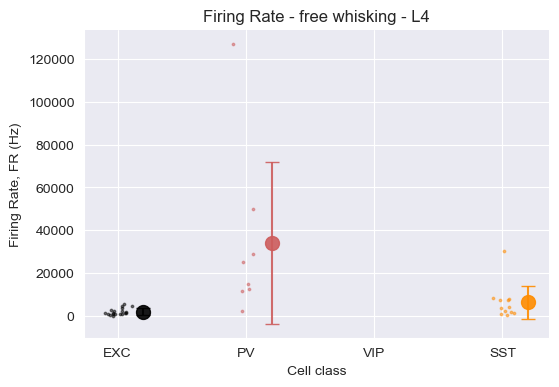

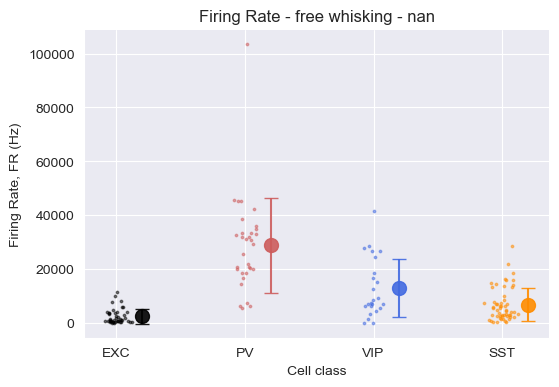

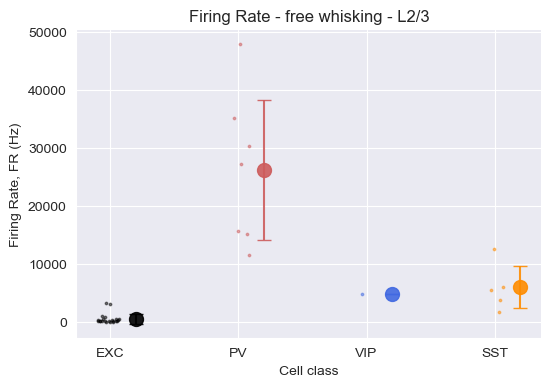

In [17]:
for layer in result_df.cell_layer.unique():

    l2 = result_df[result_df.cell_layer==layer]
    # Define figure
    fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(6,4), dpi=100)
    remove_top_right_frame(ax)

    # Iterate over cell class
    for i, c_type in enumerate(cell_class_order):

        n_cells = len(l2[l2.cell_type==c_type])
        obs_locations = [i]*n_cells #create a list int, to place observations categorically
        obs_values = l2[l2.cell_type==c_type]['firing_rate'].values * 1000 #in mV

        # Show individual observations (scatterplot with added x-axis jitter to avoid overplotting)
        jitter_scatterplot(x=obs_locations,
                           y=obs_values,
                           s=3,
                           alpha=0.5,
                           c=class_color[c_type])

        # Show mean and standard deviation
        ax.errorbar(x=i+0.2,
                    y=np.nanmean(obs_values),
                    yerr=np.nanstd(obs_values), #errobarsize is standard deviation
                    marker='o',
                    ms=10,
                    capsize=5,
                    alpha=0.9,
                    c=class_color[c_type])

    # Set xtick labels and legend
    ax.set_xticks([0,1,2,3])
    ax.set_xticklabels(cell_class_order)
    ax.set_xlabel('Cell class')
    ax.set_ylabel('Firing Rate, FR (Hz)')
    ax.set_title('Firing Rate - free whisking - %s' %layer)

C:\Users\xagao\AppData\Local\Temp\ipykernel_18552\2618941128.py:24: RuntimeWarning: Mean of empty slice
  y=np.nanmean(obs_values),
C:\Users\xagao\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


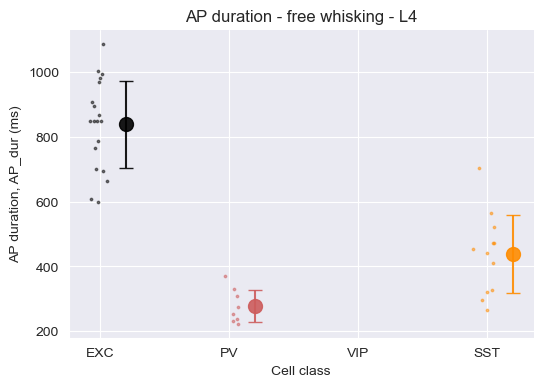

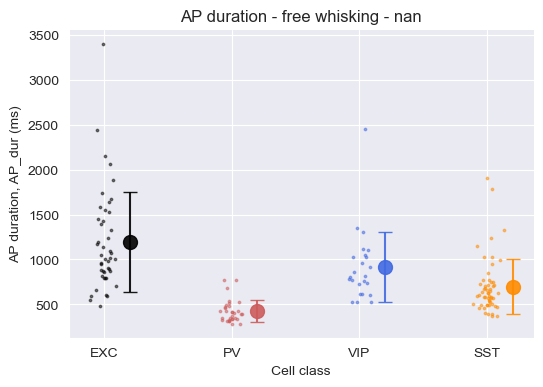

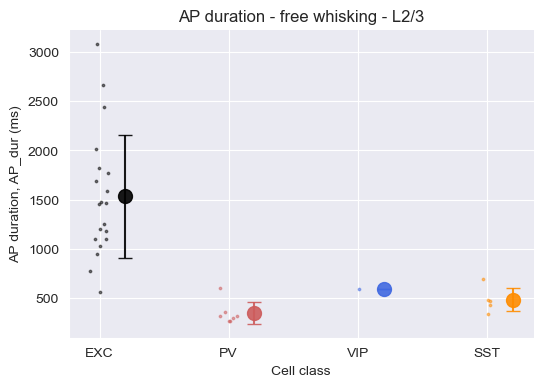

In [18]:
for layer in result_df.cell_layer.unique():

    l2 = result_df[result_df.cell_layer==layer]
    # Define figure
    fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(6,4), dpi=100)
    remove_top_right_frame(ax)

    # Iterate over cell class
    for i, c_type in enumerate(cell_class_order):

        n_cells = len(l2[l2.cell_type==c_type])
        obs_locations = [i]*n_cells #create a list int, to place observations categorically
        obs_values = l2[l2.cell_type==c_type]['ap_duration'].values * 1000 #in mV

        # Show individual observations (scatterplot with added x-axis jitter to avoid overplotting)
        jitter_scatterplot(x=obs_locations,
                           y=obs_values,
                           s=3,
                           alpha=0.5,
                           c=class_color[c_type])

        # Show mean and standard deviation
        ax.errorbar(x=i+0.2,
                    y=np.nanmean(obs_values),
                    yerr=np.nanstd(obs_values), #errobarsize is standard deviation
                    marker='o',
                    ms=10,
                    capsize=5,
                    alpha=0.9,
                    c=class_color[c_type])

    # Set xtick labels and legend
    ax.set_xticks([0,1,2,3])
    ax.set_xticklabels(cell_class_order)
    ax.set_xlabel('Cell class')
    ax.set_ylabel('AP duration, AP_dur (ms)')
    ax.set_title('AP duration - free whisking - %s' %layer)

C:\Users\xagao\AppData\Local\Temp\ipykernel_18552\1903654056.py:24: RuntimeWarning: Mean of empty slice
  y=np.nanmean(obs_values),
C:\Users\xagao\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


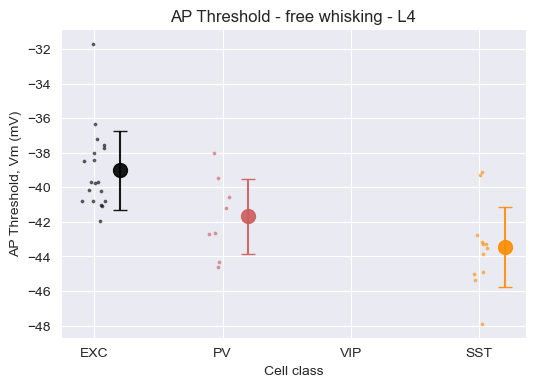

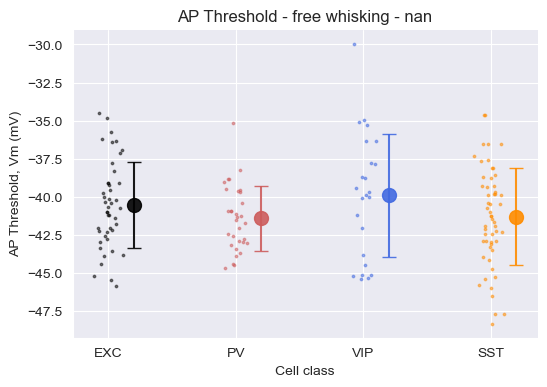

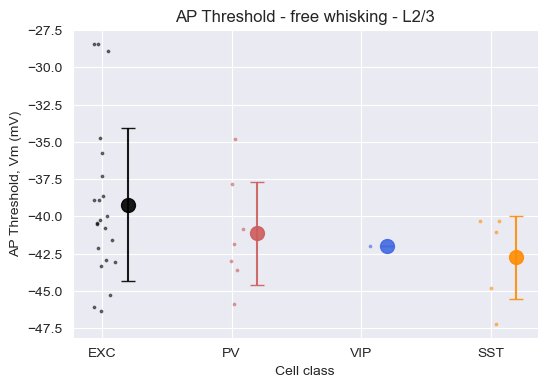

In [20]:
for layer in result_df.cell_layer.unique():

    l2 = result_df[result_df.cell_layer==layer]
    # Define figure
    fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(6,4), dpi=100)
    remove_top_right_frame(ax)

    # Iterate over cell class
    for i, c_type in enumerate(cell_class_order):

        n_cells = len(l2[l2.cell_type==c_type])
        obs_locations = [i]*n_cells #create a list int, to place observations categorically
        obs_values = l2[l2.cell_type==c_type]['ap_threshold'].values * 1000 #in mV

        # Show individual observations (scatterplot with added x-axis jitter to avoid overplotting)
        jitter_scatterplot(x=obs_locations,
                           y=obs_values,
                           s=3,
                           alpha=0.5,
                           c=class_color[c_type])

        # Show mean and standard deviation
        ax.errorbar(x=i+0.2,
                    y=np.nanmean(obs_values),
                    yerr=np.nanstd(obs_values), #errobarsize is standard deviation
                    marker='o',
                    ms=10,
                    capsize=5,
                    alpha=0.9,
                    c=class_color[c_type])

    # Set xtick labels and legend
    ax.set_xticks([0,1,2,3])
    ax.set_xticklabels(cell_class_order)
    ax.set_xlabel('Cell class')
    ax.set_ylabel('AP Threshold, Vm (mV)')
    ax.set_title('AP Threshold - free whisking - %s' %layer)